In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import scanpy as sc
import torch
import scarches as sca
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Download Dataset and split into reference dataset and query dataset

In [4]:
adata = sc.read('pbmc_vars_sb.h5ad')

In [5]:
adata = adata[adata.obs['study']!='Villani'].copy()

In [6]:
adata.X = adata.layers["counts"].copy()

In [7]:
kang = sc.read('kang_count.h5ad')[:, adata.var_names].copy()

In [8]:
kang.obs['study'] = 'Kang'
kang.obs['batch'] = 'Kang'

In [9]:
adata = sc.AnnData.concatenate(adata, kang, batch_key='batch_join')

In [10]:
sca.add_annotations(adata, 'c2.cp.reactome.v4.0.symbols.gmt', min_genes=12)

In [11]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [12]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    flavor="seurat_v3",
    batch_key="batch",
    subset=True)

In [13]:
select_terms = adata.varm['I'].sum(0)>12

In [14]:
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()

In [15]:
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [16]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [17]:
rm_terms = ['INTERFERON_SIGNALING', 'INTERFERON_ALPHA_BETA_SIGNALIN']

In [18]:
ix_f = []
for t in rm_terms:
    ix_f.append(adata.uns['terms'].index(t))

In [19]:
for i in ix_f:
    del adata.uns['terms'][i]

In [20]:
adata.varm['I'] = np.delete(adata.varm['I'], ix_f, axis=1)

In [21]:
#adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [22]:
adata.strings_to_categoricals()

... storing 'batch' as categorical
... storing 'chemistry' as categorical
... storing 'data_type' as categorical
... storing 'final_annotation' as categorical
... storing 'sample_ID' as categorical
... storing 'species' as categorical
... storing 'study' as categorical
... storing 'tissue' as categorical
... storing 'orig.ident' as categorical
... storing 'stim' as categorical
... storing 'seurat_annotations' as categorical
... storing 'condition' as categorical
... storing 'cell_type' as categorical


In [23]:
adata.obs['cell_type_joint'] = adata.obs['final_annotation'].tolist()

In [24]:
idx_1 = adata.obs['cell_type_joint'].astype(str) == 'nan'
idx_2 = adata.obs['cell_type'].astype(str) != 'nan'
adata.obs['cell_type_joint'][idx_1] = adata.obs['cell_type'][idx_2].tolist()

In [25]:
categories = np.unique(adata.obs['cell_type_joint'])

In [26]:
celltypes_replace = {}
celltypes_replace['CD20+ B cells'] = 'B'
celltypes_replace['CD4 T'] = 'CD4+ T cells'
celltypes_replace['CD8 T'] = 'CD8+ T cells'
celltypes_replace['CD14 Mono'] = 'CD14+ Monocytes'
celltypes_replace['CD16 Mono'] = 'CD16+ Monocytes'
celltypes_replace['NK'] = 'NK cells'

In [27]:
for cat in categories:
    if cat in celltypes_replace:
        adata.obs['cell_type_joint'][adata.obs['cell_type_joint']==cat] = celltypes_replace[cat]

### Create TRVAE model and train it on reference dataset

In [32]:
intr_cvae = sca.models.TRVAE(
    adata=adata,
    condition_key='study',
    hidden_layer_sizes=[256, 256, 256],
    use_mmd=False,
    recon_loss='nb',
    mask=adata.varm['I'].T,
    use_decoder_relu=False,
    n_ext_decoder=3,
    n_expand_encoder=3,
    soft_mask=False,
    use_hsic=True,
    hsic_one_vs_all=True
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1979 256 5
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 278
	Expanded Mean/Var Layer in/out: 256 3
Decoder Architecture:
	Cond layer in, ext, cond, out and :  278 3 5 1979
	with hard mask.


In [33]:
ALPHA = 0.7

In [34]:
OMEGA = None

In [ ]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=400, 
    alpha_epoch_anneal=100, 
    alpha=ALPHA, 
    omega=OMEGA,
    alpha_l1=None,
    gamma_ext=0.6,
    alpha_kl=0.5,
    beta=1.,
    weight_decay=0., 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    print_n_deactive=True,
    seed=2020
)

In [45]:
inactive_idx = ~intr_cvae.model.decoder.nonzero_terms()

In [46]:
ext_active = (intr_cvae.model.decoder.L0.ext_L.weight.data.abs() > 0).sum(0).cpu().numpy() > 20

In [47]:
inactive_idx[-len(ext_active):] = ~ext_active

In [48]:
terms = adata.uns['terms'].copy()

In [63]:
terms += ['unannotated_' + str(i) for i in range(len(ext_active))]

In [50]:
print('Inactive terms:')
[term for i, term in enumerate(adata.uns['terms']) if inactive_idx[i]]

Inactive terms:


['APOPTOTIC_CLEAVAGE_OF_CELLULAR',
 'DAG_AND_IP3_SIGNALING',
 'BMAL1_CLOCK_NPAS2_ACTIVATES_CI',
 'G0_AND_EARLY_G1',
 'O_LINKED_GLYCOSYLATION_OF_MUCI',
 'SULFUR_AMINO_ACID_METABOLISM',
 'SPHINGOLIPID_DE_NOVO_BIOSYNTHE',
 'PI3K_EVENTS_IN_ERBB4_SIGNALING',
 'PI3K_EVENTS_IN_ERBB2_SIGNALING',
 'EXTRACELLULAR_MATRIX_ORGANIZAT',
 'NOTCH1_INTRACELLULAR_DOMAIN_RE',
 'SIGNALLING_TO_ERKS',
 'COLLAGEN_FORMATION',
 'SYNTHESIS_OF_PIPS_AT_THE_PLASM',
 'PI_METABOLISM',
 'CHONDROITIN_SULFATE_DERMATAN_S',
 'LATENT_INFECTION_OF_HOMO_SAPIE',
 'NUCLEAR_EVENTS_KINASE_AND_TRAN',
 'PI3K_AKT_ACTIVATION',
 'BASIGIN_INTERACTIONS',
 'GAB1_SIGNALOSOME',
 'PHOSPHORYLATION_OF_CD3_AND_TCR',
 'NRAGE_SIGNALS_DEATH_THROUGH_JN',
 'CYTOSOLIC_TRNA_AMINOACYLATION',
 'NUCLEAR_RECEPTOR_TRANSCRIPTION',
 'RNA_POL_II_TRANSCRIPTION_PRE_I',
 'GPVI_MEDIATED_ACTIVATION_CASCA',
 'PERK_REGULATED_GENE_EXPRESSION',
 'NCAM_SIGNALING_FOR_NEURITE_OUT',
 'CLASS_B_2_SECRETIN_FAMILY_RECE',
 'SEMA4D_INDUCED_CELL_MIGRATION_',
 'G_ALPHA_Z_SIGNAL

In [51]:
MEAN = False

In [52]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [53]:
sc.pp.neighbors(adata, use_rep='X_cvae')

In [54]:
sc.tl.umap(adata)

... storing 'cell_type_joint' as categorical


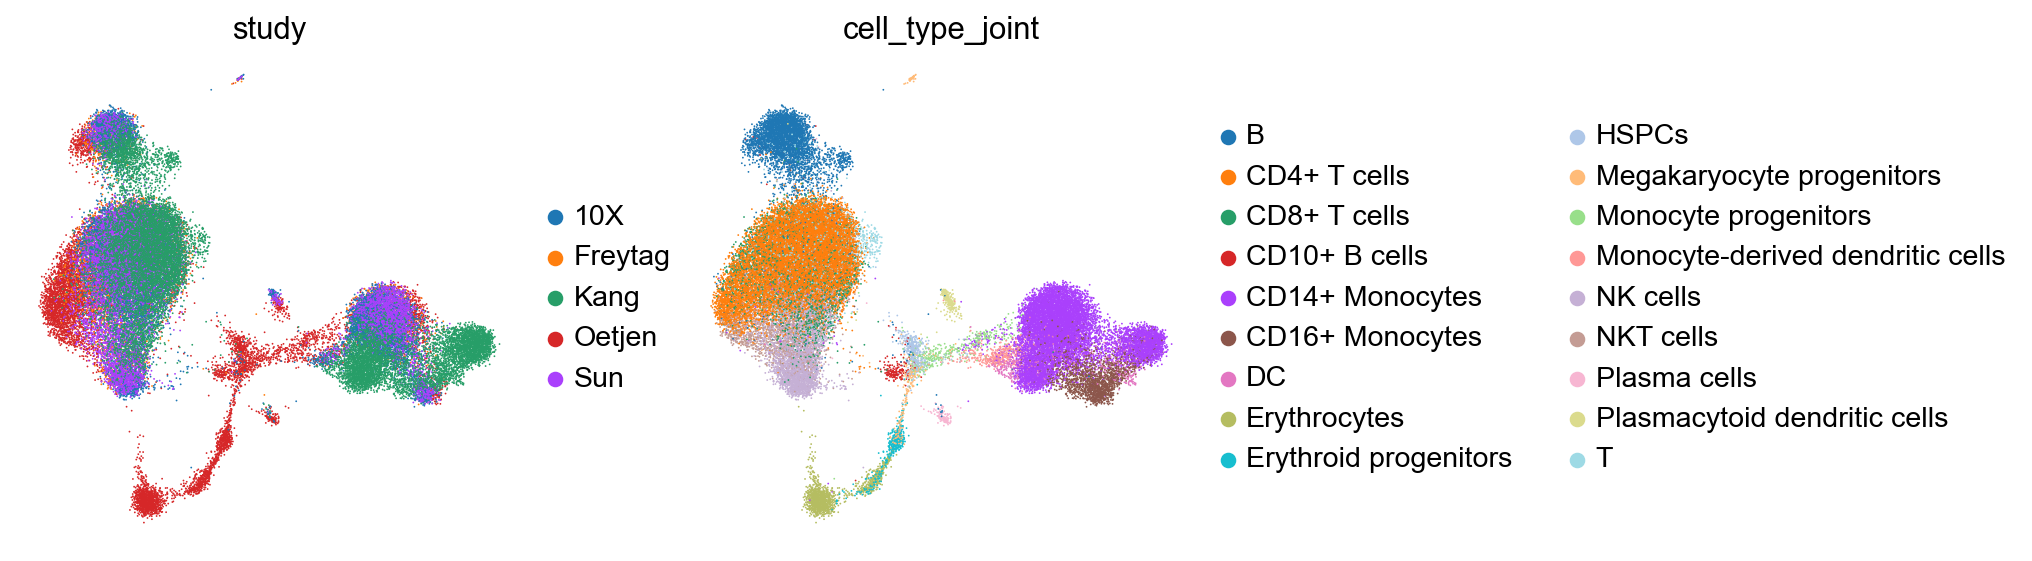

In [55]:
sc.pl.umap(adata, color=['study', 'cell_type_joint'], frameon=False)

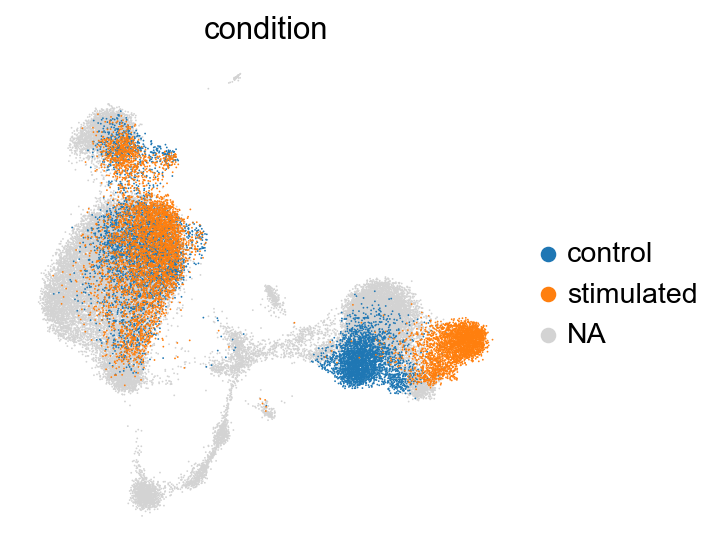

In [56]:
sc.pl.umap(adata, color='condition', frameon=False)

In [ ]:
#intr_cvae.save('intr_cvae_nb_mmd_beta_15')

In [57]:
ext_active

array([False, False,  True, False])

In [64]:
# select term name here
idx = [terms.index(term) for term in ['unannotated_0', 'SIGNALING_BY_THE_B_CELL_RECEPT']]

In [65]:
latents = intr_cvae.get_latent(mean=MEAN)[:, idx]

In [66]:
adata.obs['unannotated'] = latents[:, 0]
adata.obs['SIGNALING_BY_THE_B_CELL_RECEPT'] = latents[:, 1]

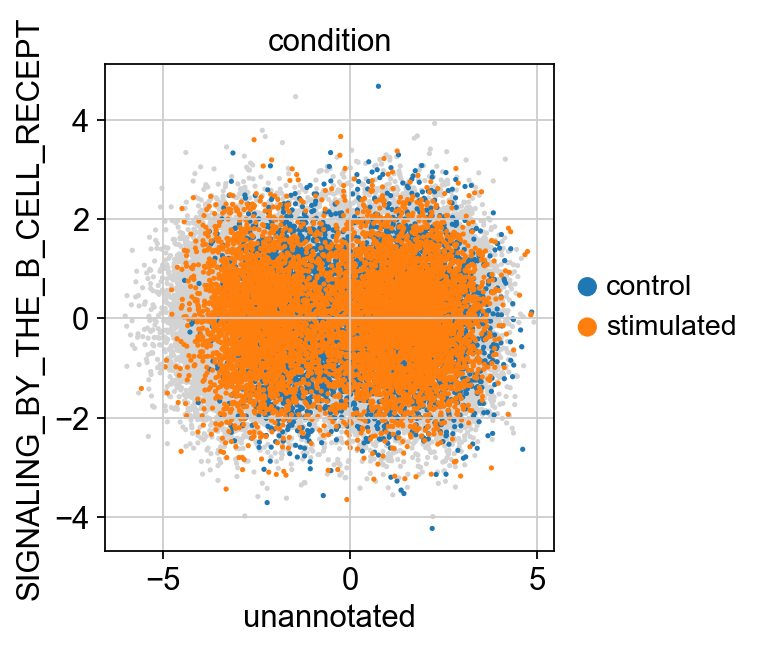

In [67]:
sc.pl.scatter(adata, x='unannotated', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='condition', size=22)

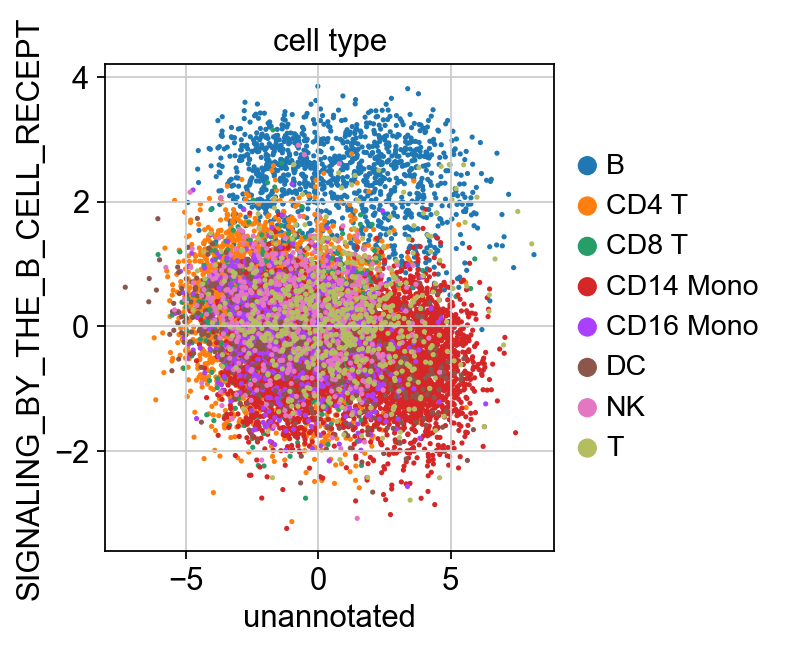

In [299]:
sc.pl.scatter(adata, x='unannotated', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='cell_type_joint', size=22)

In [191]:
IFN_GENES = ['ADAR','ARIH1', 'B2M','CAMK2D', 'CD44','CIITA', 'DDX58', 'EGR1', 'EIF2AK2', 'EIF4A3',
             'EIF4E', 'EIF4E3', 'EIF4G3', 'FCGR1A', 'FCGR1B', 'GBP1', 'GBP2', 'GBP4', 'GBP5', 'HERC5', 
             'HLA-A', 'HLA-B', 'HLA-C', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DQA1', 'HLA-DQA2', 'HLA-DRB1', 
             'HLA-DRB5', 'HLA-F', 'HLA-G', 'ICAM1', 'IFI27', 'IFI35', 'IFI6', 'IFIT1', 'IFIT2', 'IFIT3', 
             'IFITM1', 'IFITM2', 'IFITM3', 'IFNAR1', 'IFNAR2', 'IFNG', 'IFNGR1', 'IFNGR2', 'IRF1', 'IRF2', 
             'IRF3', 'IRF4', 'IRF5', 'IRF7', 'IRF8', 'IRF9', 'ISG15', 'ISG20', 'JAK1', 'JAK2', 'KPNA1', 
             'KPNA2', 'MAPK3', 'MT2A', 'MX1', 'MX2', 'NCAM1', 'NUP205', 'NUP210', 'NUP214', 'NUP50', 
             'NUP88', 'NUPL2', 'OAS1', 'OAS2', 'OAS3', 'OASL', 'PIAS1', 'PLCG1', 'PML', 'PPM1B', 'PRKCD', 
             'PTAFR', 'PTPN1', 'PTPN6', 'RANBP2', 'SOCS1', 'SOCS3', 'STAT1', 'STAT2', 'TRIM25', 'TYK2',
             'UBA7', 'USP18', 'XAF1']

In [192]:
IFN_A_B_GENES = ['ISG15', 'IFI6', 'JAK1', 'GBP2', 'ADAR', 'STAT1', 'IRF2', 'IRF1', 'EGR1', 'IRF4', 
                 'HLA-F', 'HLA-G', 'HLA-A', 'HLA-C', 'HLA-B', 'IRF5', 'IFITM2', 'IFITM1', 'IFITM3', 
                 'IRF7', 'IFIT2', 'IFIT3', 'IFIT1', 'PTPN6', 'STAT2', 'OAS1', 'OAS3', 'OAS2', 'OASL',
                 'IRF9', 'IFI27', 'ISG20', 'SOCS1', 'IRF8', 'XAF1', 'IFI35', 'SOCS3', 'PTPN1', 'TYK2', 
                 'IRF3', 'USP18', 'IFNAR2', 'IFNAR1', 'MX2', 'MX1']

In [333]:
unann_idx = 0

In [334]:
unann_genes = adata.var_names[(intr_cvae.model.decoder.L0.ext_L.weight.data.abs()[:, unann_idx]>0).cpu().numpy()].tolist()

In [335]:
len(set(unann_genes).intersection(IFN_GENES))

43

In [336]:
len(set(unann_genes).intersection(IFN_A_B_GENES))

24

In [337]:
srt = np.argsort(intr_cvae.model.decoder.L0.ext_L.weight.data.abs()[:, unann_idx].cpu().numpy())[::-1]

In [338]:
unann_genes_top = adata.var_names[srt[:100]].tolist()

In [339]:
len(set(unann_genes_top).intersection(IFN_GENES))

19

In [340]:
len(set(unann_genes_top).intersection(IFN_A_B_GENES))

10

In [341]:
# monocyte related

In [346]:
len(set(unann_genes_top).intersection(intr_cvae.terms_genes()['SIGNALING_BY_GPCR']))

11

In [348]:
len(set(unann_genes_top).intersection(intr_cvae.terms_genes()['METABOLISM_OF_CARBOHYDRATES']))

4

In [350]:
len(set(unann_genes_top).intersection(intr_cvae.terms_genes()['METABOLISM_OF_AMINO_ACIDS_AND_']))

5